In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
import sys
sys.path.insert(0, 'drive/Bitirme Tezi/2016.c/CNN')

In [4]:
!pip install -q keras

In [5]:
ls

adc.json  drive/  sample_data/


In [6]:
cd drive/Bitirme Tezi/2016.c/CNN

/content/drive/Bitirme Tezi/2016.c/CNN


Import the libraries

In [12]:
import os,random
import numpy as np
import pandas as pd
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle
from keras.callbacks import ModelCheckpoint
import itertools

In [13]:
#%% load dataset
dataSetLoad = pickle.load(open("2016.04C.multisnr.pkl", 'rb'), encoding='latin')
len(dataSetLoad.keys())        #number of keys
dataSetLoad['8PSK', -20]       #elements of this key
dataSetLoad['8PSK', -16].shape #shape of this key

(413, 2, 128)

In [14]:
SNRs, modulation_types = map(lambda j: sorted(list(set(map(lambda x: x[j], dataSetLoad.keys())))), [1,0]) #SNRs and modulation types
dataSet   = []
data8PSK  = [] 
dataAMDSB = []
dataAMSSB = []
dataBPSK  = []
dataCPFSK = []
dataGFSK  = []
dataPAM4  = []
dataQAM16 = []
dataQAM64 = []
dataQPSK  = []
dataWBFM  = []
label = []
for mod in modulation_types:
    for snr in SNRs:
        if mod == '8PSK':
            data8PSK.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-DSB':
            dataAMDSB.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-SSB':
            dataAMSSB.append(dataSetLoad[(mod,snr)])
        if mod == 'BPSK':
            dataBPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'CPFSK':
            dataCPFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'GFSK':
            dataGFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'PAM4':
            dataPAM4.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM16':
            dataQAM16.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM64':
            dataQAM64.append(dataSetLoad[(mod,snr)])
        if mod == 'QPSK':
            dataQPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'WBFM':
            dataWBFM.append(dataSetLoad[(mod,snr)])
        
        dataSet.append(dataSetLoad[(mod,snr)])
        for i in range(dataSetLoad[(mod,snr)].shape[0]):  
            label.append((mod,snr))
            
dataSet = np.vstack(dataSet)
print(len(dataSet))

162060


In [15]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
train_index   = []
np.random.seed(2020)
totalNumberSignals = dataSet.shape[0]
n_train = int(totalNumberSignals * 7 / 10)
train_index = np.random.choice(range(0,totalNumberSignals), size=n_train, replace=False)
random.shuffle(train_index) # suffling
test_index = list(set(range(0,totalNumberSignals))-set(train_index))

X_train = dataSet[train_index]
X_train = X_train.reshape(len(X_train),X_train[0].shape[0], X_train[0].shape[1], 1 )
X_test =  dataSet[test_index]
X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1)

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+ 1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), train_index)))
Y_test = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), test_index)))

in_shape = list(X_train.shape[1:])
print ("X_train shape", X_train.shape)
print ("X_test shape", X_test.shape)
print ("in shape", in_shape)



X_train shape (113442, 2, 128, 1)
X_test shape (48618, 2, 128, 1)
in shape [2, 128, 1]


In [16]:
in_shape = list(X_train.shape[1:])
print ("X_train shape", X_train.shape)
print ("X_test shape", X_test.shape)
print ("in shape", in_shape)


X_train shape (113442, 2, 128, 1)
X_test shape (48618, 2, 128, 1)
in shape [2, 128, 1]


In [17]:
# %% CNN Model Tanımlama
def get_model():
  model = Sequential()
  # 1. KATMAN
  model.add(Conv2D(256, (1, 3), data_format = "channels_last",activation ="relu", kernel_initializer='he_normal', input_shape=(2,128,1)))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 2. KATMAN
  model.add(Conv2D(128, (2, 3), activation ="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 3. KATMAN
  model.add(Conv2D(64, (1, 3), activation ="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 4. KATMAN
  model.add(Conv2D(32, (1, 3), activation ="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # Fully Connected Layer
  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dense(128,activation='relu'))
  # çıkış katmanı
  model.add(Dense(len(modulation_types),activation='softmax' ))
  model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )#optimizasyon ve başarım hesaplama metriklerinin belirlenmesi
  model.summary()
  return model

In [18]:
model1 = get_model()
model2 = get_model()
model3 = get_model()
model4 = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 126, 256)       1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 126, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 2, 126, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 124, 128)       196736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 124, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 124, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 122, 64)        2

In [19]:
# %% Eğitim ve ağırlıkların .h5 uzantılı dosya şeklinde kaydedilmesi
# en başarılı ağırlıkları kaydet
batchsize1 = 64
batchsize2 = 128
batchsize3 = 512
batchsize4 = 1024
def train_model(batch_size_, model):
    epochs = 100
    # perform training ...
    #   - call the main training loop in keras for our network+dataset
    filepath = 'modulation_model.h5'
    history = model.fit(X_train,
        Y_train,
        batch_size=batch_size_,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, Y_test),
            callbacks = [
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),

            ])
    model.load_weights(filepath)
    return model, history 


In [20]:
print('model1 is training')
trained_model1, history1 = train_model(batchsize1, model1)
print('model2 is training')
trained_model2, history2 = train_model(batchsize2, model2)
print('model3 is training')
trained_model3, history3 = train_model(batchsize3, model3)
print('model4 is training')
trained_model4, history4 = train_model(batchsize4, model4)

model1 is training
Epoch 1/100
1773/1773 [==============================] - 37s 11ms/step - loss: 1.8177 - accuracy: 0.3299 - val_loss: 1.0936 - val_accuracy: 0.5793

Epoch 00001: val_loss improved from inf to 1.09357, saving model to modulation_model.h5
Epoch 2/100
1773/1773 [==============================] - 20s 11ms/step - loss: 1.1143 - accuracy: 0.5676 - val_loss: 0.9932 - val_accuracy: 0.6123

Epoch 00002: val_loss improved from 1.09357 to 0.99322, saving model to modulation_model.h5
Epoch 3/100
1773/1773 [==============================] - 19s 11ms/step - loss: 1.0205 - accuracy: 0.6033 - val_loss: 0.9563 - val_accuracy: 0.6276

Epoch 00003: val_loss improved from 0.99322 to 0.95630, saving model to modulation_model.h5
Epoch 4/100
1773/1773 [==============================] - 19s 11ms/step - loss: 0.9871 - accuracy: 0.6178 - val_loss: 0.9322 - val_accuracy: 0.6373

Epoch 00004: val_loss improved from 0.95630 to 0.93220, saving model to modulation_model.h5
Epoch 5/100
1773/1773 [==

In [21]:
# Show simple version of performance
train_loss, train_acc  = trained_model1.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 64', train_loss)
print('train_acc- batch size = 64', train_acc)
test_loss, test_acc  = trained_model1.evaluate(X_test, Y_test, verbose = 1)
print('test loss- batch size = 64', test_loss)
print('test accuracy- batch size = 64', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model2.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 128', train_loss)
print('train_acc - batch size = 128', train_acc)
test_loss, test_acc  = trained_model2.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 128', test_loss)
print('test accuracy - batch size = 128', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model3.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 512', train_loss)
print('train_acc - batch size = 512', train_acc)
test_loss, test_acc  = trained_model3.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 512', test_loss)
print('test accuracy - batch size = 512', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model4.evaluate(X_train, Y_train, verbose = 1)
print('train_loss  - batch size = 1024', train_loss)
print('train_acc  - batch size = 1024 ', train_acc)
test_loss, test_acc  = trained_model4.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 1024 ', test_loss)
print('test accuracy  - batch size = 1024 ', test_acc)


3546/3546 [==============================] - 13s 4ms/step - loss: 0.7390 - accuracy: 0.7234
train_loss - batch size = 64 0.7389756441116333
train_acc- batch size = 64 0.7234445810317993
1520/1520 [==============================] - 6s 4ms/step - loss: 0.8670 - accuracy: 0.6733
test loss- batch size = 64 0.8670016527175903
test accuracy- batch size = 64 0.6733102798461914
3546/3546 [==============================] - 13s 4ms/step - loss: 0.7667 - accuracy: 0.7095
train_loss - batch size = 128 0.7667340040206909
train_acc - batch size = 128 0.709507942199707
1520/1520 [==============================] - 6s 4ms/step - loss: 0.8701 - accuracy: 0.6685
test loss - batch size = 128 0.8700584769248962
test accuracy - batch size = 128 0.6685383915901184
3546/3546 [==============================] - 13s 4ms/step - loss: 0.7477 - accuracy: 0.7147
train_loss - batch size = 512 0.747698962688446
train_acc - batch size = 512 0.7147000432014465
1520/1520 [==============================] - 6s 4ms/step - l

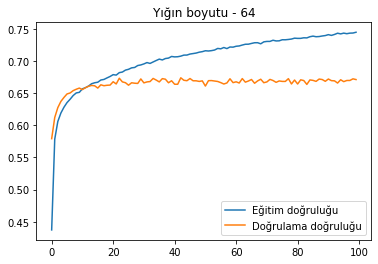

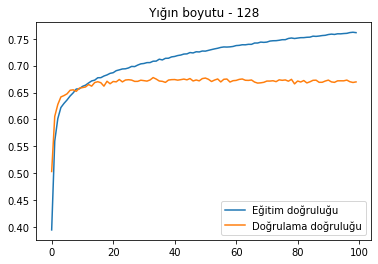

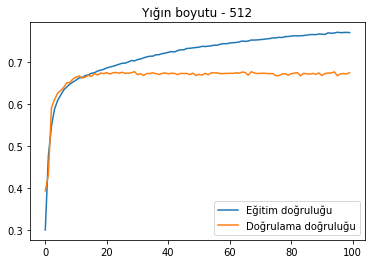

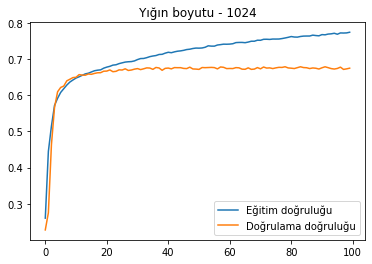

In [22]:
plt.figure(1)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history1.epoch, history1.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(2)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history2.epoch, history2.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(3)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history3.epoch, history3.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(4)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history4.epoch, history4.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

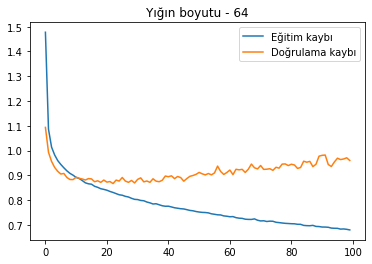

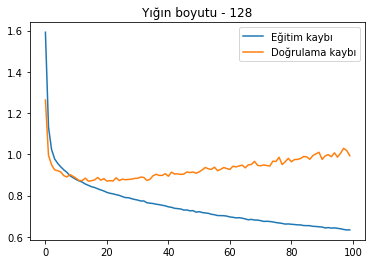

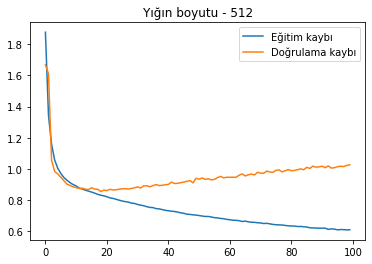

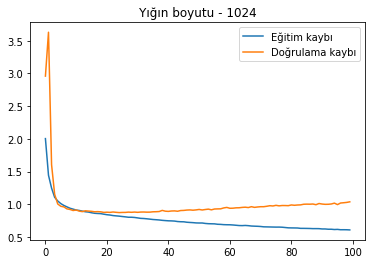

In [23]:
# Show loss curves 
plt.figure(5)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['loss'], label='Eğitim kaybı')
plt.plot(history1.epoch, history1.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

# Show loss curves 
plt.figure(6)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['loss'], label='Eğitim kaybı')
plt.plot(history2.epoch, history2.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(7)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['loss'], label='Eğitim kaybı')
plt.plot(history3.epoch, history3.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(8)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['loss'], label='Eğitim kaybı')
plt.plot(history4.epoch, history4.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

In [24]:
def plot_confusion_matrix(cm, title='CNN', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize = 12)
    plt.yticks(tick_marks, labels, fontsize = 12)
    plt.tight_layout()
    plt.ylabel('Gerçek sınıf', fontsize = 12 )
    plt.xlabel('Tahmin edilen sınıf', fontsize = 12)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                  fontsize=12,
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

In [25]:
# Plot confusion matrix
def plot_cm_to_batchsize(model, batchsize_):
  test_Y_hat = model.predict(X_test, batch_size=batchsize_)
  conf = np.zeros([len(modulation_types),len(modulation_types)])
  confnorm = np.zeros([len(modulation_types),len(modulation_types)])
  for i in range(0,X_test.shape[0]):
      j = list(Y_test[i,:]).index(1)
      k = int(np.argmax(test_Y_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
  for i in range(0,len(modulation_types)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
  plt.figure(3)
  plot_confusion_matrix(confnorm, labels=modulation_types)  

<Figure size 432x288 with 0 Axes>

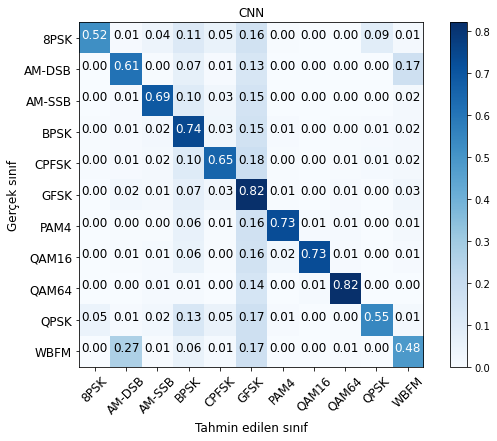

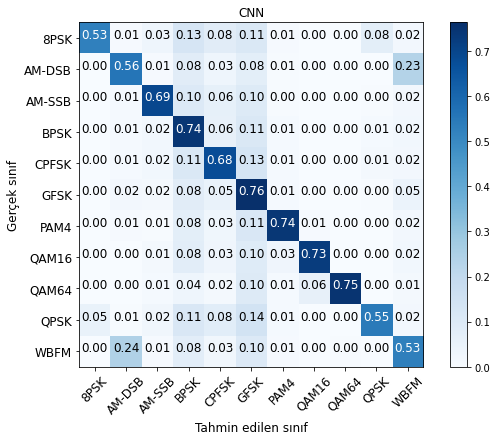

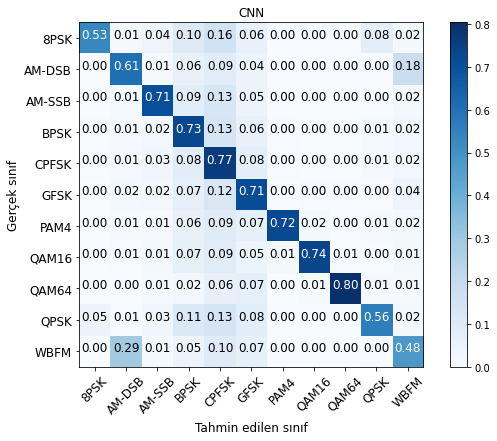

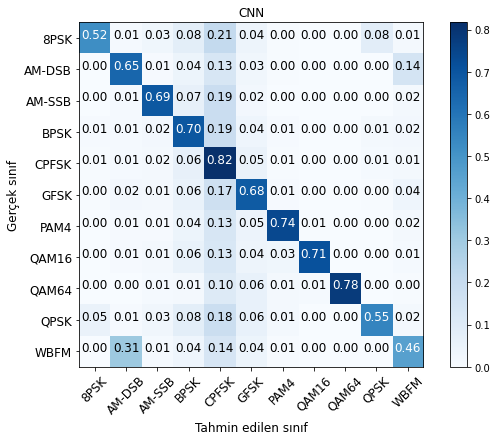

In [26]:
plot_cm_to_batchsize(trained_model1, batchsize1)
plot_cm_to_batchsize(trained_model2, batchsize2)
plot_cm_to_batchsize(trained_model3, batchsize3)
plot_cm_to_batchsize(trained_model4, batchsize4)

In [27]:
# Plot confusion matrix
def plot_cm_snr(model, batch_size):
  acc = {}
  for snr in SNRs:
      # extract modulation_types @ SNR
      test_SNRs = list(map(lambda x: label[x][1], test_index))
      test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
      test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

      # estimate modulation_types
      test_Y_i_hat = model.predict(test_X_i)
      conf = np.zeros([len(modulation_types),len(modulation_types)])
      confnorm = np.zeros([len(modulation_types),len(modulation_types)])
      for i in range(0,test_X_i.shape[0]):
          j = list(test_Y_i[i,:]).index(1)
          k = int(np.argmax(test_Y_i_hat[i,:]))
          conf[j,k] = conf[j,k] + 1
      for i in range(0,len(modulation_types)):
          confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
      plt.figure()
      plot_confusion_matrix(confnorm, labels=modulation_types, title="CNN, SNR=%d dB, Yığın boyutu= %d"%(snr, batch_size))
      
      cor = np.sum(np.diag(conf))
      ncor = np.sum(conf) - cor
      print ("SNR : ", snr)
      print ("Overall Accuracy:", cor / (cor+ncor))
      acc[snr] = 1.0*cor/(cor+ncor)
  
  return acc

    




SNR :  -20
Overall Accuracy: 0.14140179299103506
SNR :  -18
Overall Accuracy: 0.14628199918732224
SNR :  -16
Overall Accuracy: 0.1611179613645705
SNR :  -14
Overall Accuracy: 0.2056371576022231
SNR :  -12
Overall Accuracy: 0.254790052996331
SNR :  -10
Overall Accuracy: 0.3462986198243413
SNR :  -8
Overall Accuracy: 0.5390593047034765
SNR :  -6
Overall Accuracy: 0.6849427168576104
SNR :  -4
Overall Accuracy: 0.8253382533825339
SNR :  -2
Overall Accuracy: 0.9176229508196722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


SNR :  0
Overall Accuracy: 0.9087171052631579
SNR :  2
Overall Accuracy: 0.9119017365523083
SNR :  4
Overall Accuracy: 0.9373264577548592
SNR :  6
Overall Accuracy: 0.95004095004095
SNR :  8
Overall Accuracy: 0.9168067226890756
SNR :  10
Overall Accuracy: 0.9319983312473926
SNR :  12
Overall Accuracy: 0.9448188711036226
SNR :  14
Overall Accuracy: 0.906237092110698
SNR :  16
Overall Accuracy: 0.9302904564315353
SNR :  18
Overall Accuracy: 0.9496043315285297
SNR :  -20
Overall Accuracy: 0.15892420537897312
SNR :  -18
Overall Accuracy: 0.14303128809427063
SNR :  -16
Overall Accuracy: 0.1524866420057542
SNR :  -14
Overall Accuracy: 0.21317983326716952
SNR :  -12
Overall Accuracy: 0.24459845087647777
SNR :  -10
Overall Accuracy: 0.32915098285236305
SNR :  -8
Overall Accuracy: 0.5321063394683027
SNR :  -6
Overall Accuracy: 0.6796235679214403
SNR :  -4
Overall Accuracy: 0.8220582205822058
SNR :  -2
Overall Accuracy: 0.9086065573770492
SNR :  0
Overall Accuracy: 0.9041940789473685
SNR :  2
Ov

<Figure size 432x288 with 0 Axes>

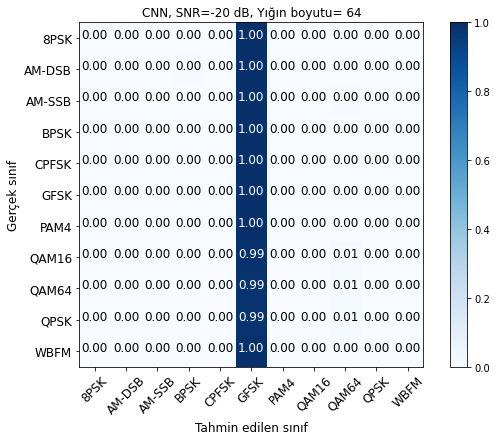

<Figure size 432x288 with 0 Axes>

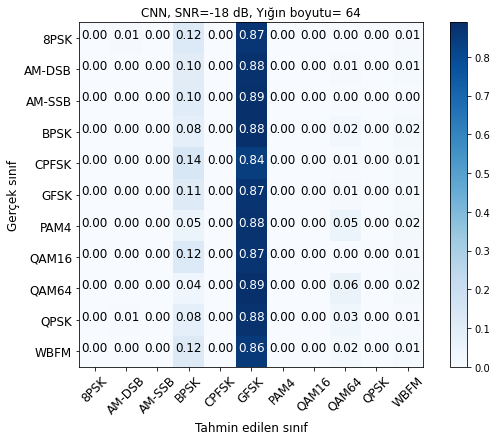

<Figure size 432x288 with 0 Axes>

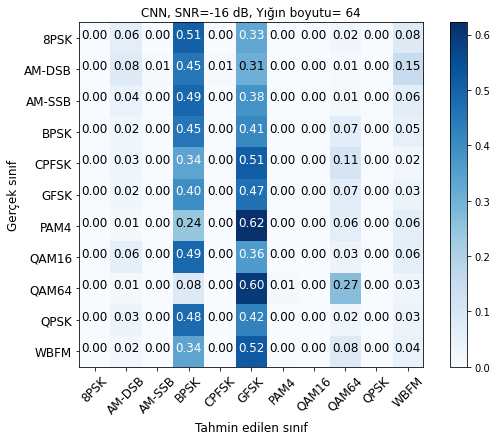

<Figure size 432x288 with 0 Axes>

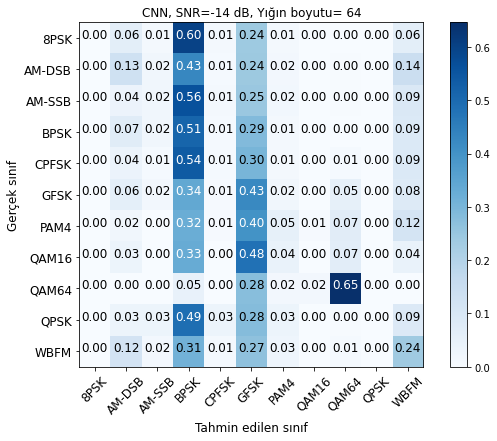

<Figure size 432x288 with 0 Axes>

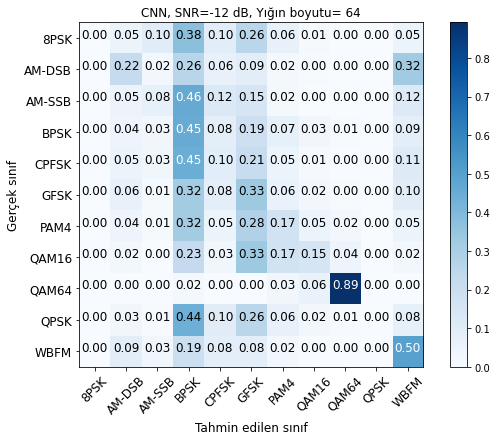

<Figure size 432x288 with 0 Axes>

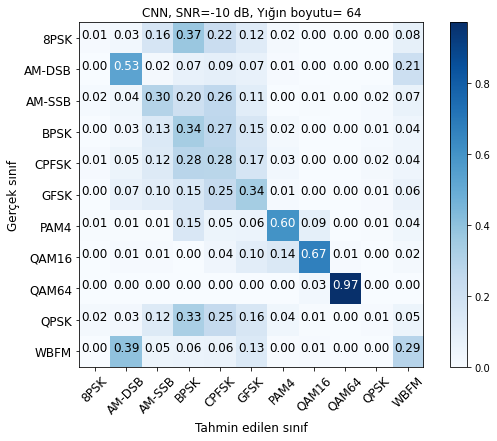

<Figure size 432x288 with 0 Axes>

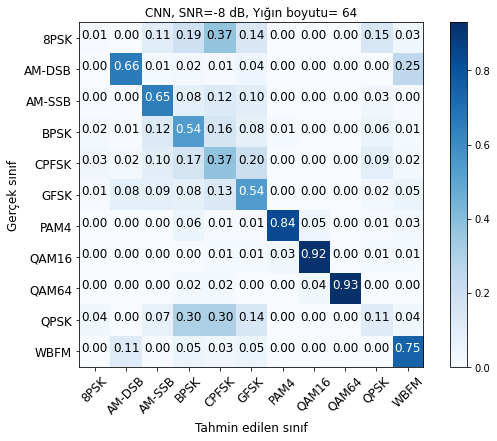

<Figure size 432x288 with 0 Axes>

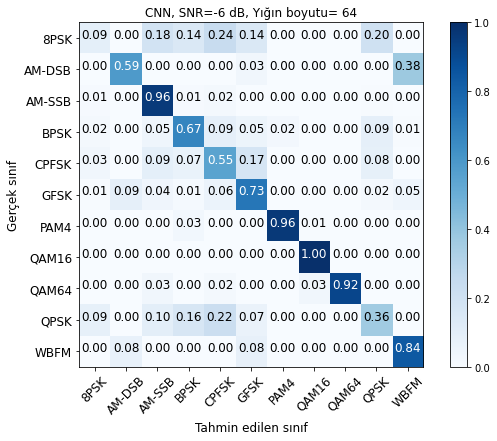

<Figure size 432x288 with 0 Axes>

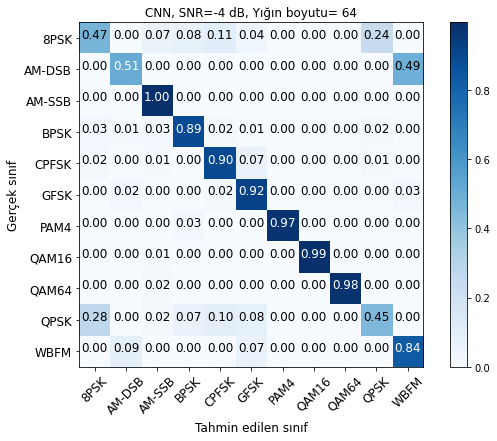

<Figure size 432x288 with 0 Axes>

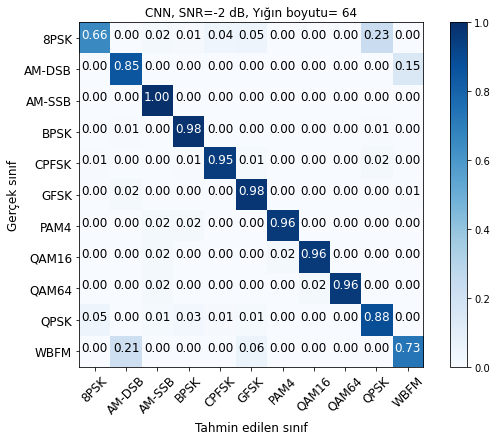

<Figure size 432x288 with 0 Axes>

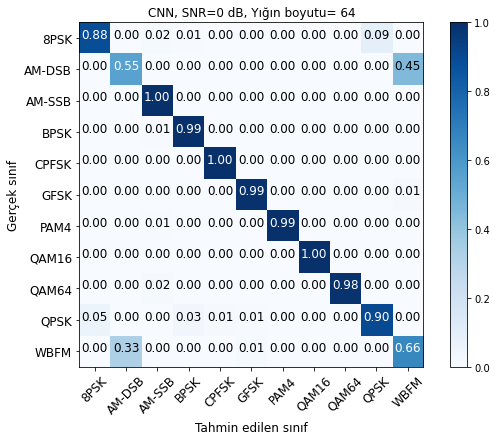

<Figure size 432x288 with 0 Axes>

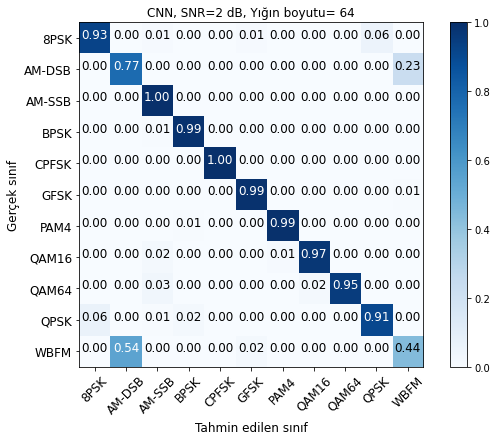

<Figure size 432x288 with 0 Axes>

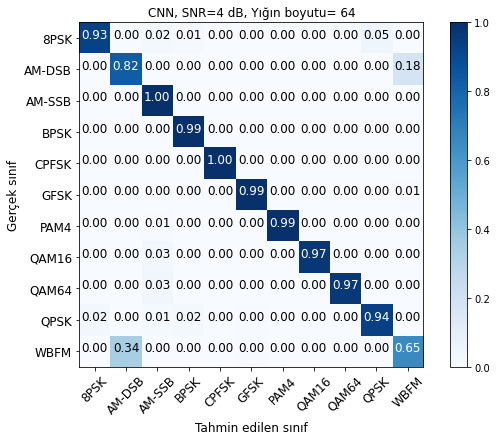

<Figure size 432x288 with 0 Axes>

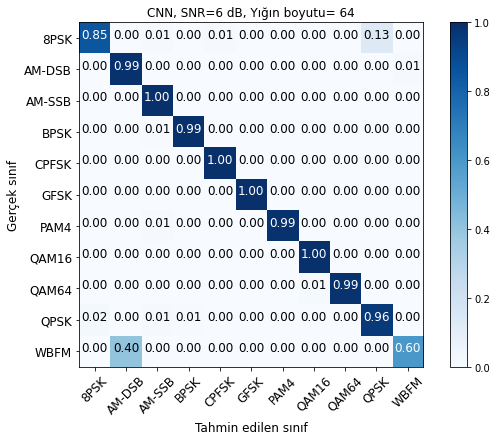

<Figure size 432x288 with 0 Axes>

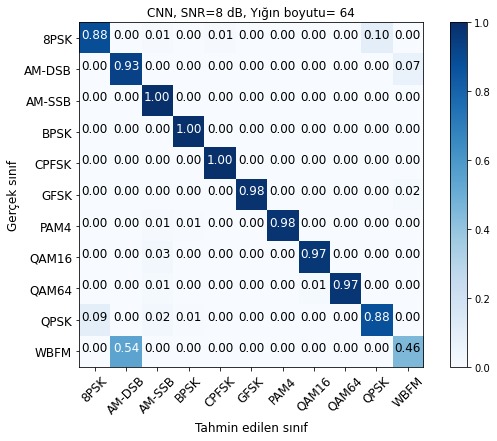

<Figure size 432x288 with 0 Axes>

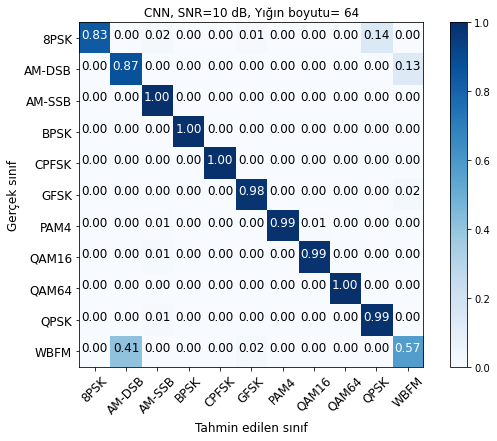

<Figure size 432x288 with 0 Axes>

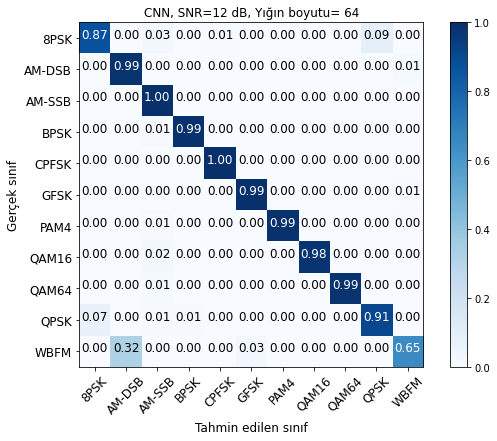

<Figure size 432x288 with 0 Axes>

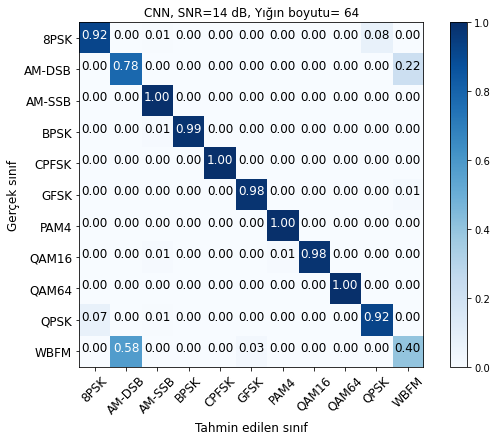

<Figure size 432x288 with 0 Axes>

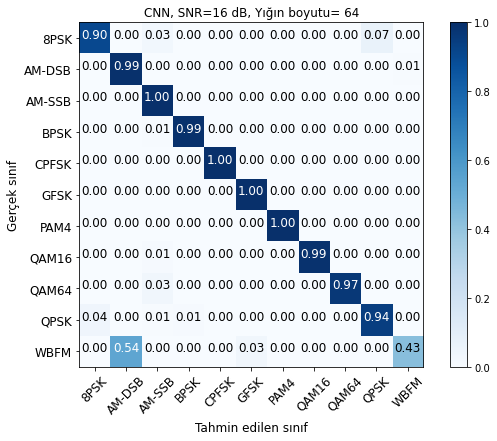

<Figure size 432x288 with 0 Axes>

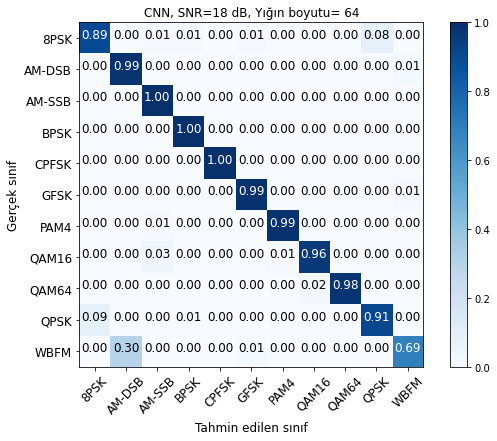

<Figure size 432x288 with 0 Axes>

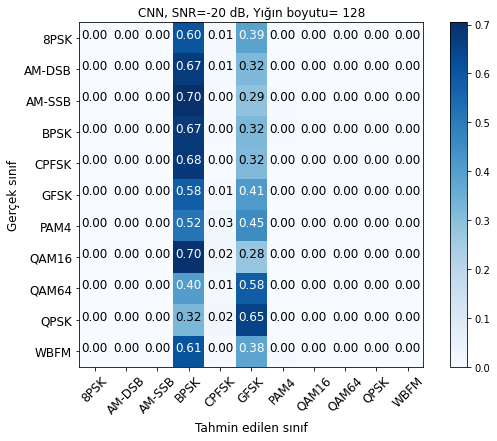

<Figure size 432x288 with 0 Axes>

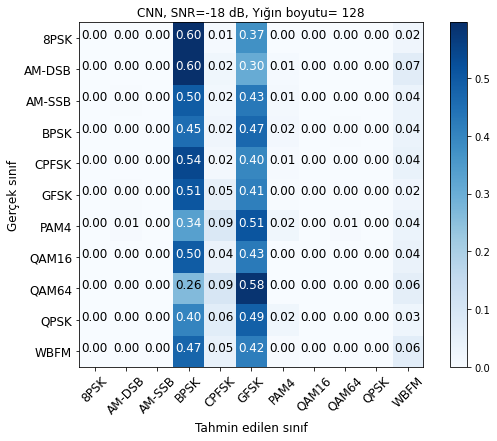

<Figure size 432x288 with 0 Axes>

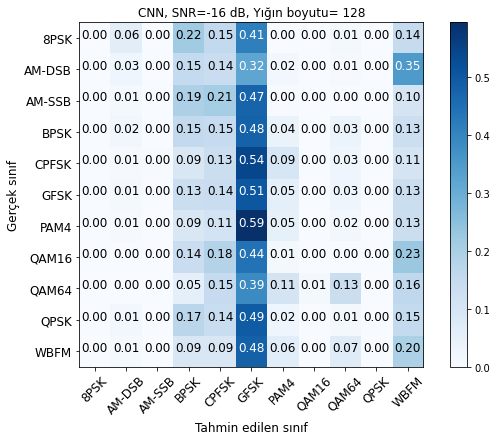

<Figure size 432x288 with 0 Axes>

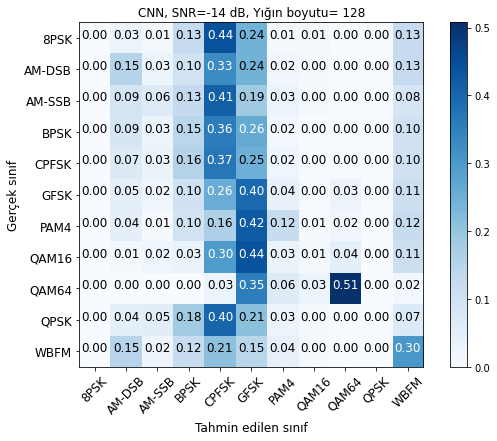

<Figure size 432x288 with 0 Axes>

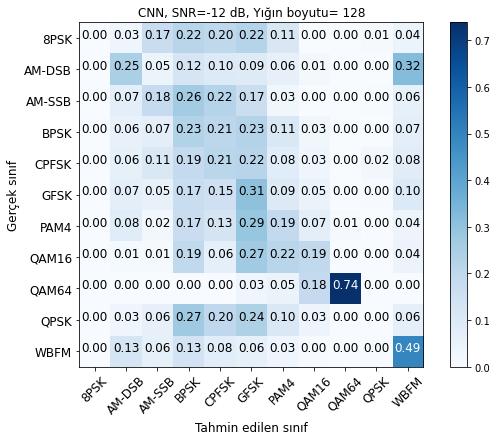

<Figure size 432x288 with 0 Axes>

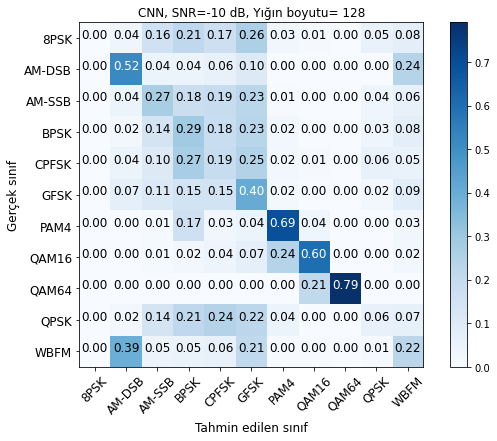

<Figure size 432x288 with 0 Axes>

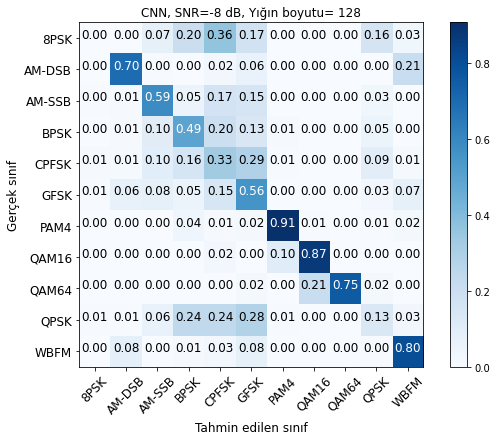

<Figure size 432x288 with 0 Axes>

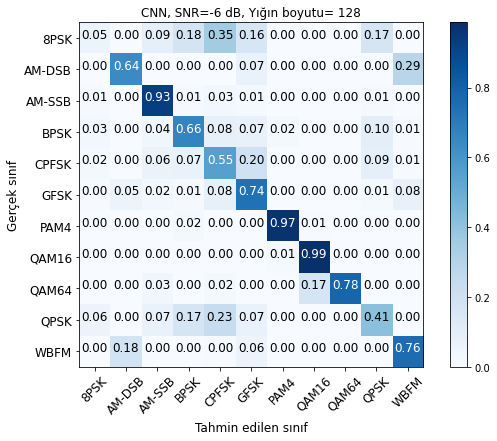

<Figure size 432x288 with 0 Axes>

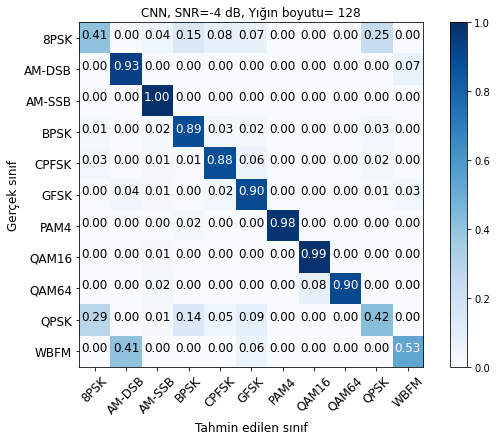

<Figure size 432x288 with 0 Axes>

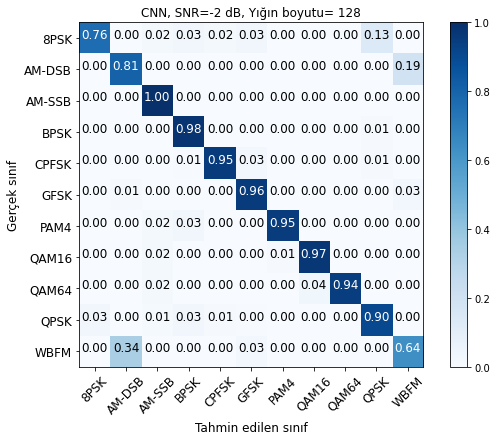

<Figure size 432x288 with 0 Axes>

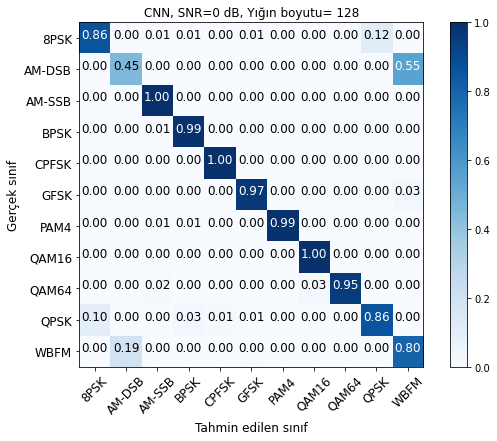

<Figure size 432x288 with 0 Axes>

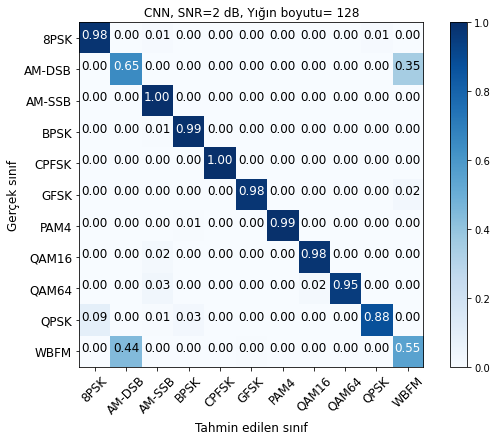

<Figure size 432x288 with 0 Axes>

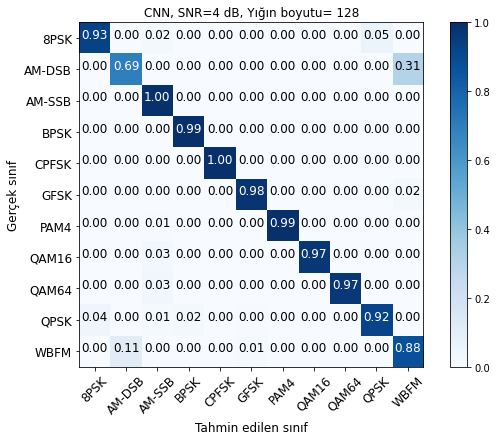

<Figure size 432x288 with 0 Axes>

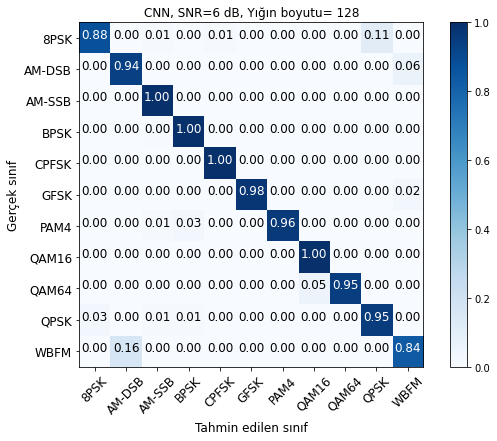

<Figure size 432x288 with 0 Axes>

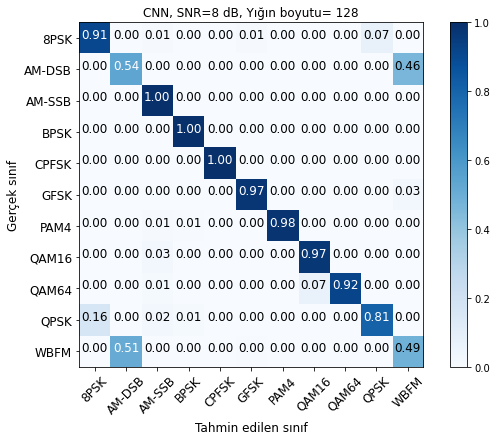

<Figure size 432x288 with 0 Axes>

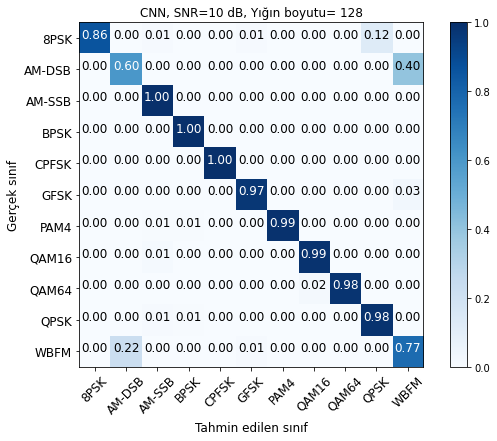

<Figure size 432x288 with 0 Axes>

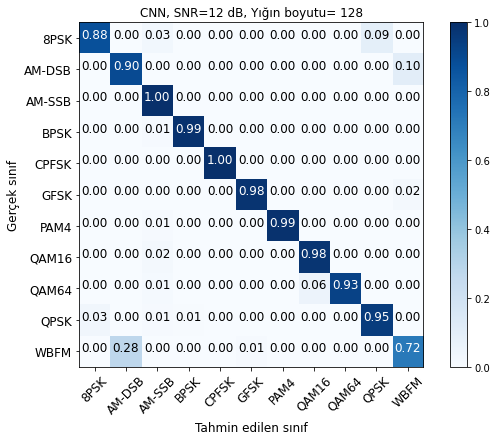

<Figure size 432x288 with 0 Axes>

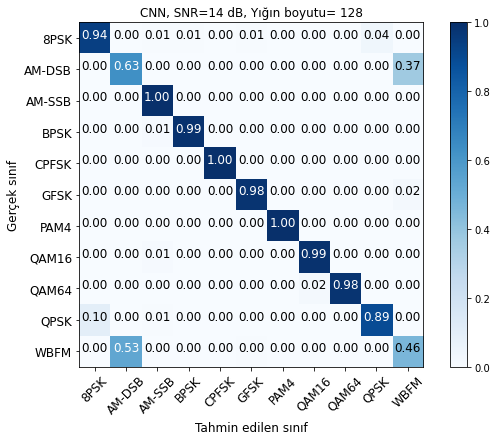

<Figure size 432x288 with 0 Axes>

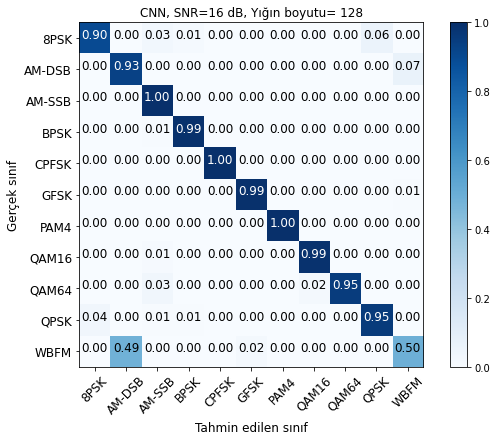

<Figure size 432x288 with 0 Axes>

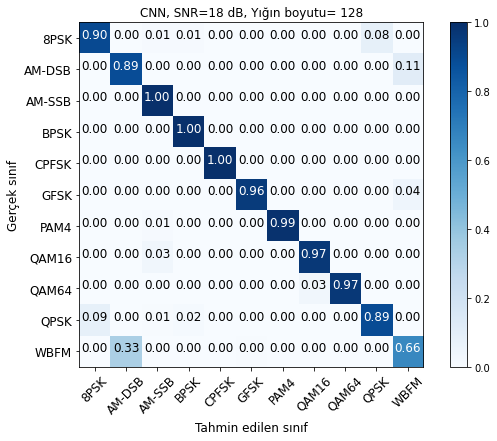

<Figure size 432x288 with 0 Axes>

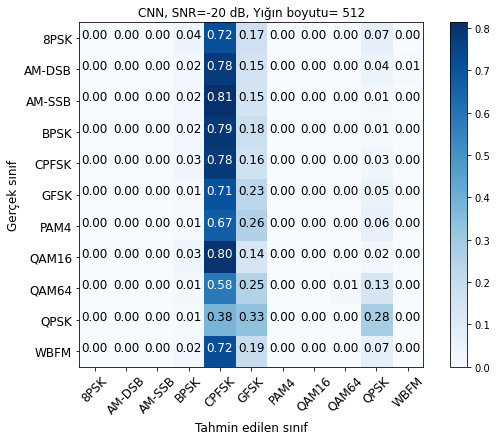

<Figure size 432x288 with 0 Axes>

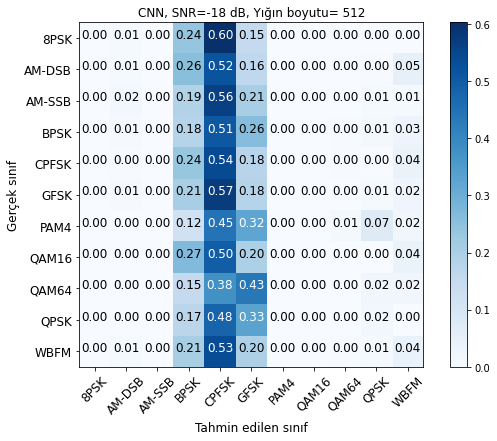

<Figure size 432x288 with 0 Axes>

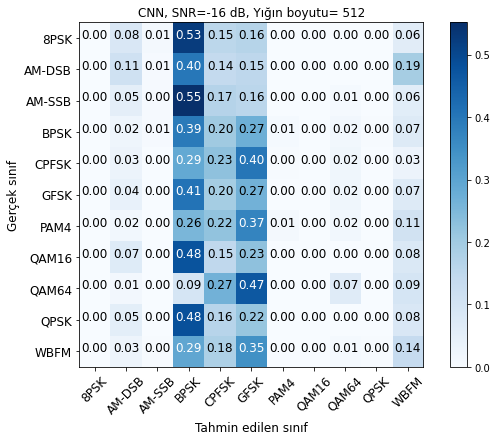

<Figure size 432x288 with 0 Axes>

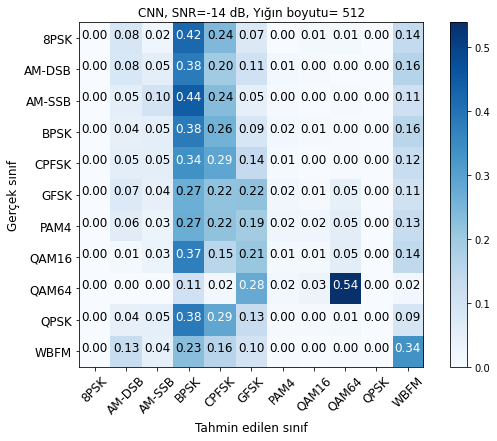

<Figure size 432x288 with 0 Axes>

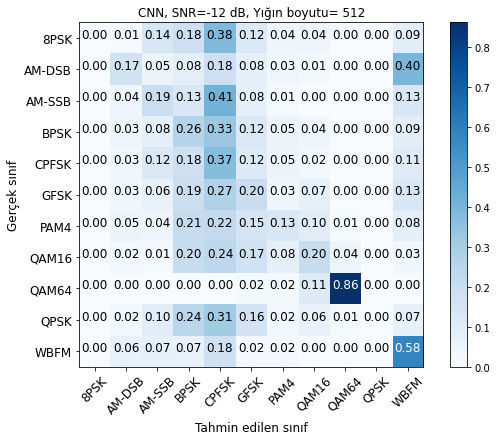

<Figure size 432x288 with 0 Axes>

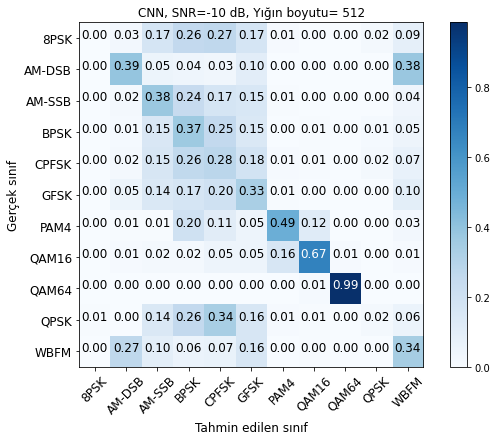

<Figure size 432x288 with 0 Axes>

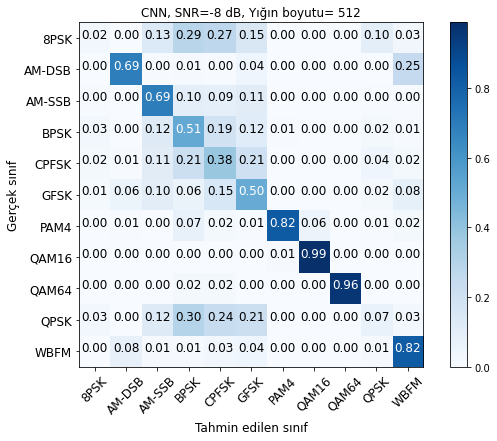

<Figure size 432x288 with 0 Axes>

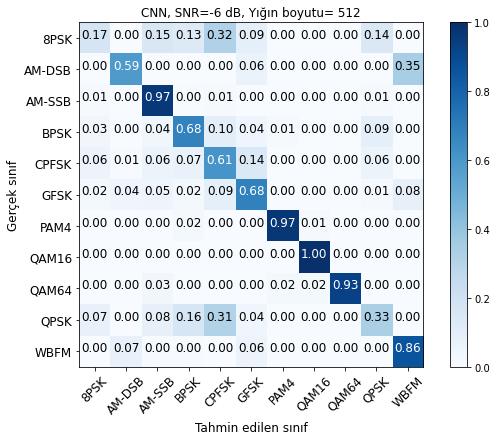

<Figure size 432x288 with 0 Axes>

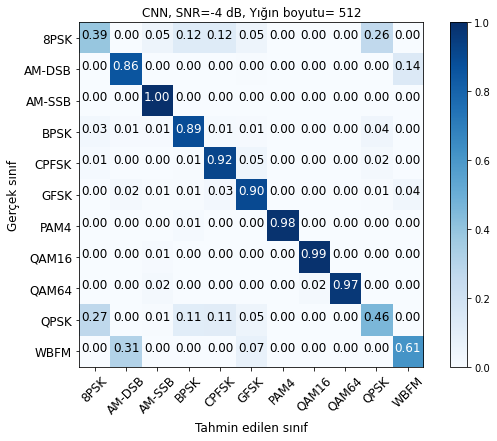

<Figure size 432x288 with 0 Axes>

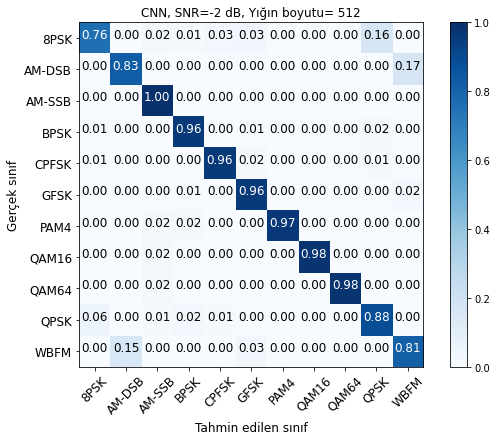

<Figure size 432x288 with 0 Axes>

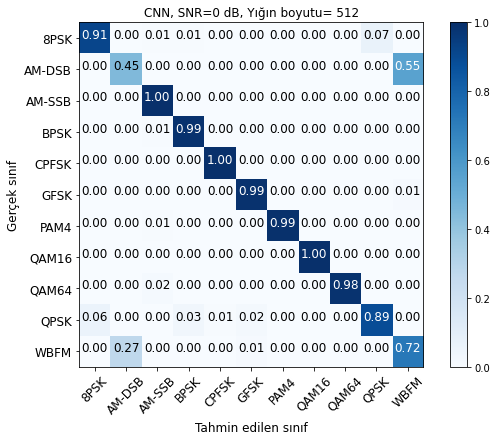

<Figure size 432x288 with 0 Axes>

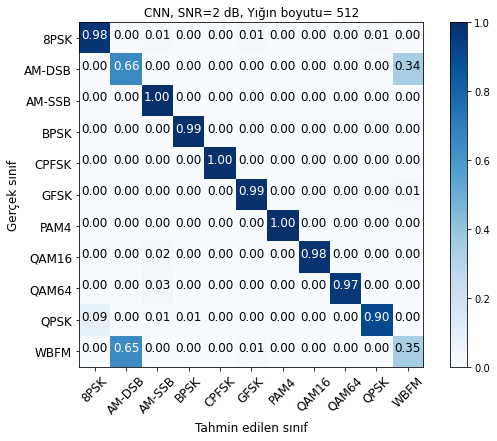

<Figure size 432x288 with 0 Axes>

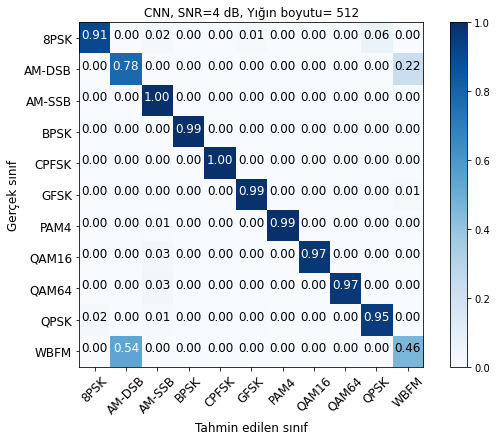

<Figure size 432x288 with 0 Axes>

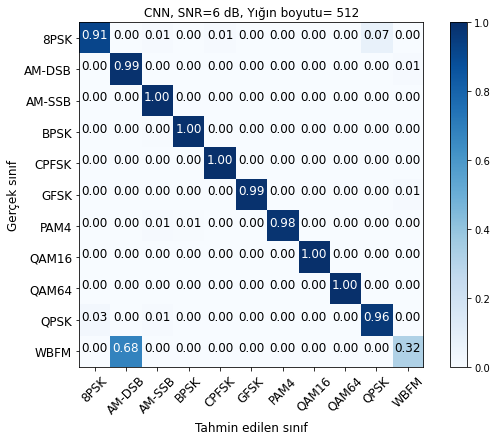

<Figure size 432x288 with 0 Axes>

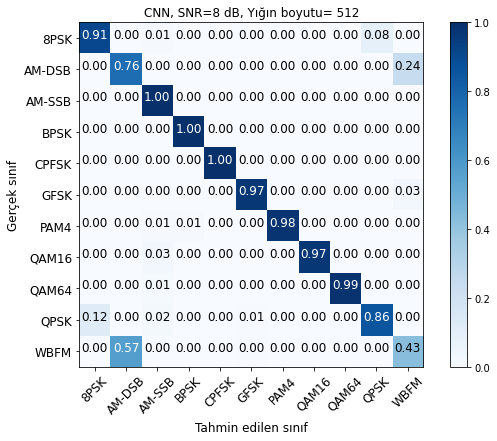

<Figure size 432x288 with 0 Axes>

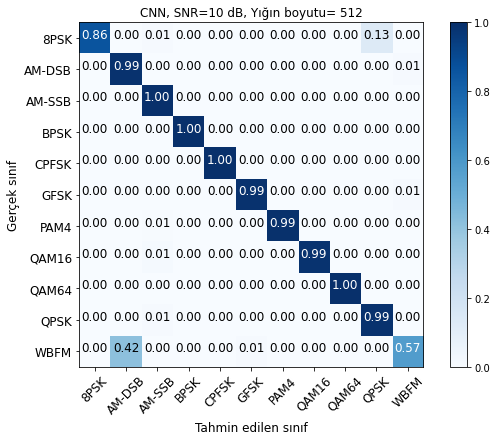

<Figure size 432x288 with 0 Axes>

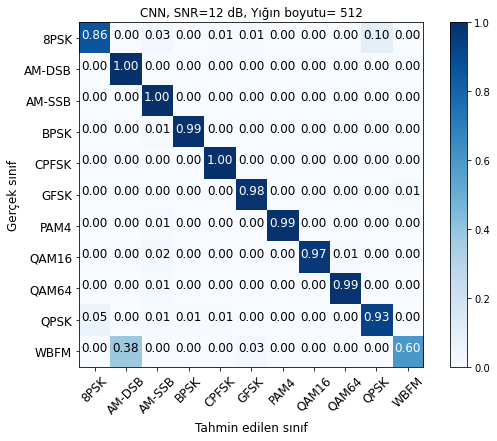

<Figure size 432x288 with 0 Axes>

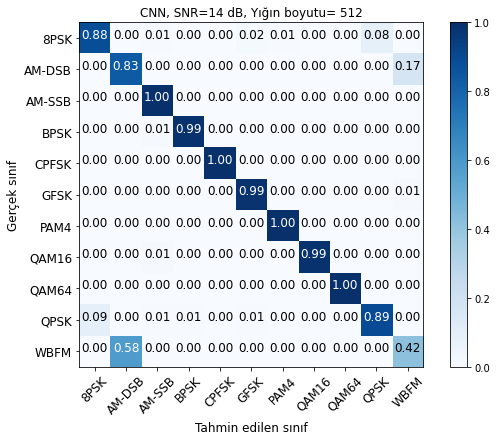

<Figure size 432x288 with 0 Axes>

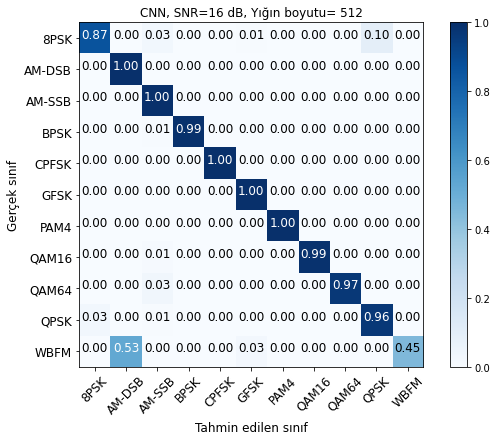

<Figure size 432x288 with 0 Axes>

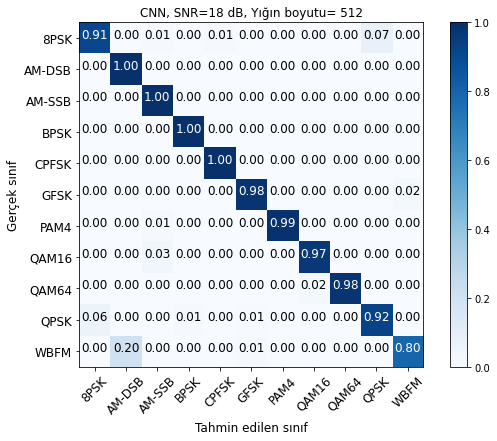

<Figure size 432x288 with 0 Axes>

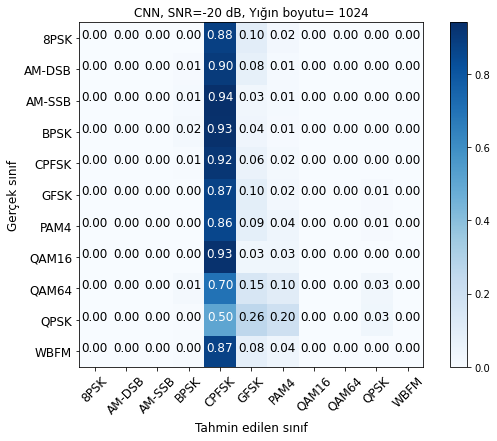

<Figure size 432x288 with 0 Axes>

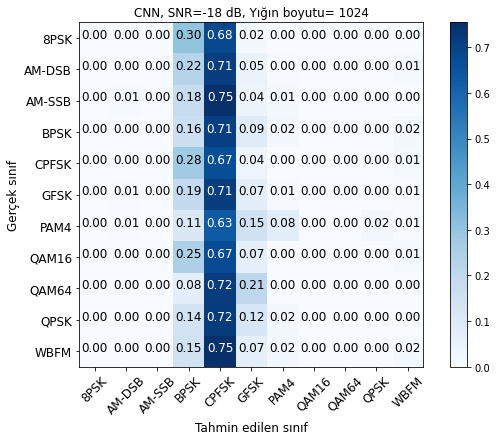

<Figure size 432x288 with 0 Axes>

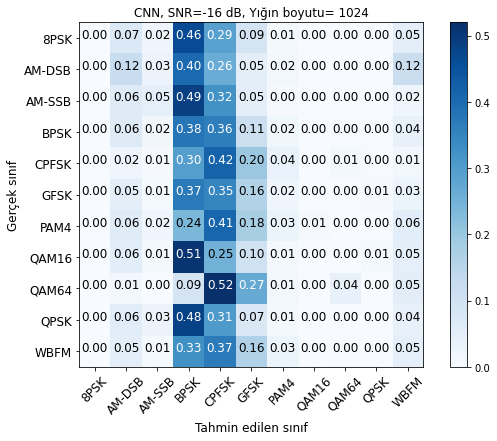

<Figure size 432x288 with 0 Axes>

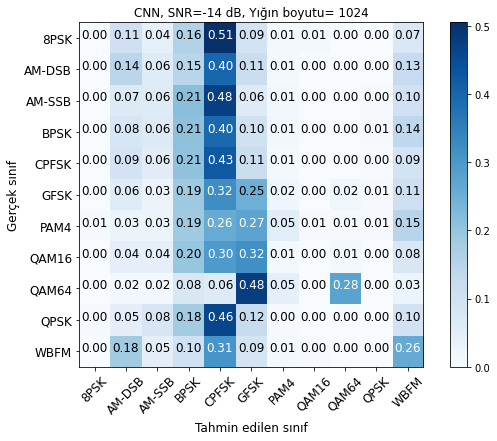

<Figure size 432x288 with 0 Axes>

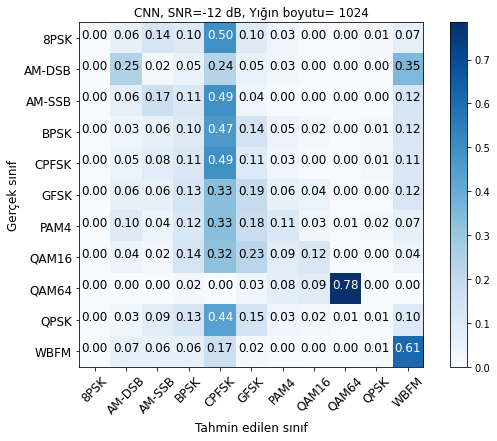

<Figure size 432x288 with 0 Axes>

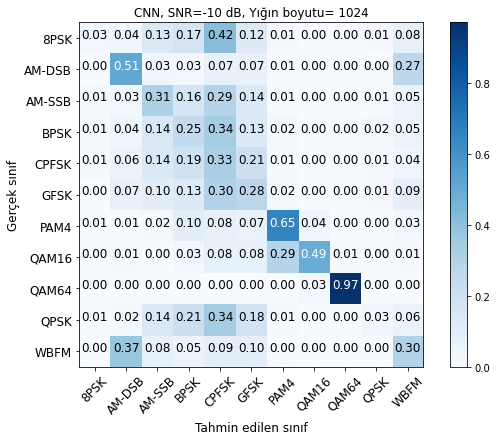

<Figure size 432x288 with 0 Axes>

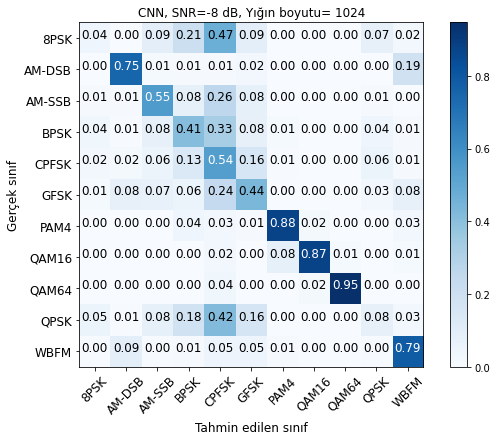

<Figure size 432x288 with 0 Axes>

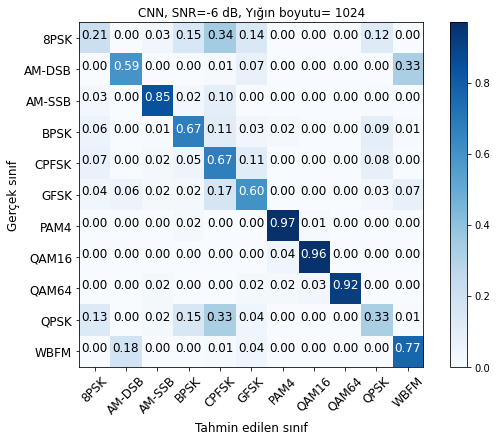

<Figure size 432x288 with 0 Axes>

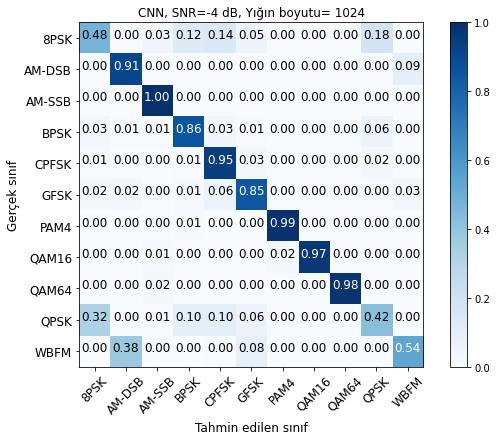

<Figure size 432x288 with 0 Axes>

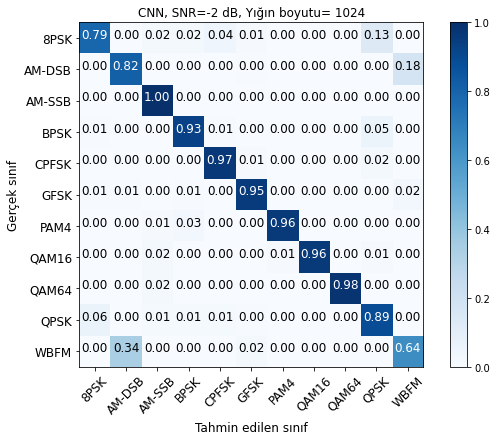

<Figure size 432x288 with 0 Axes>

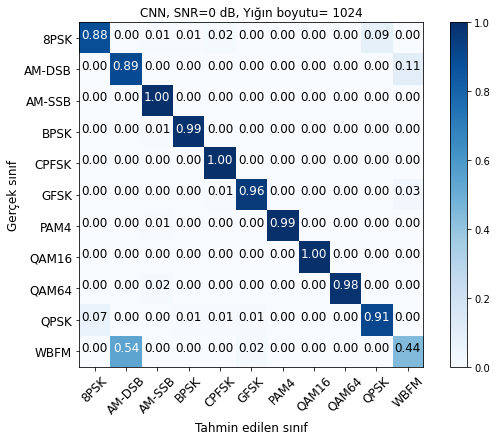

<Figure size 432x288 with 0 Axes>

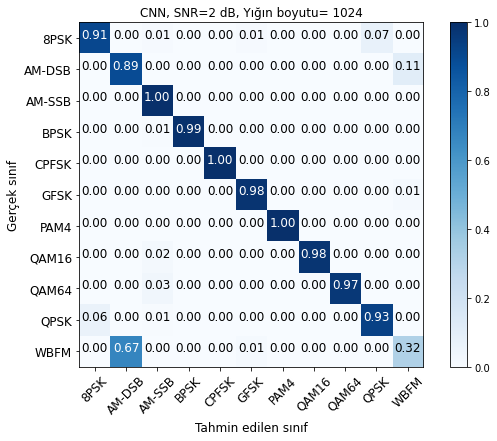

<Figure size 432x288 with 0 Axes>

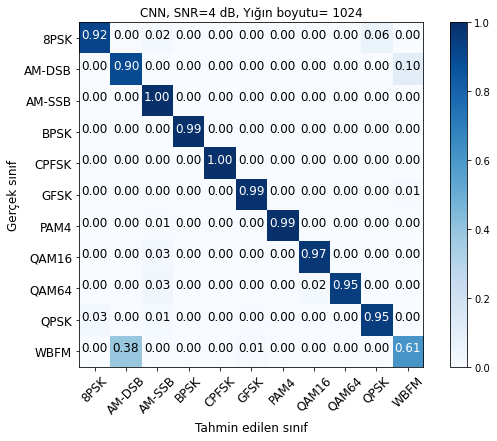

<Figure size 432x288 with 0 Axes>

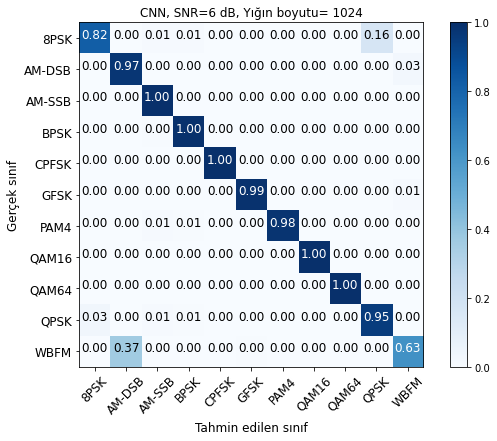

<Figure size 432x288 with 0 Axes>

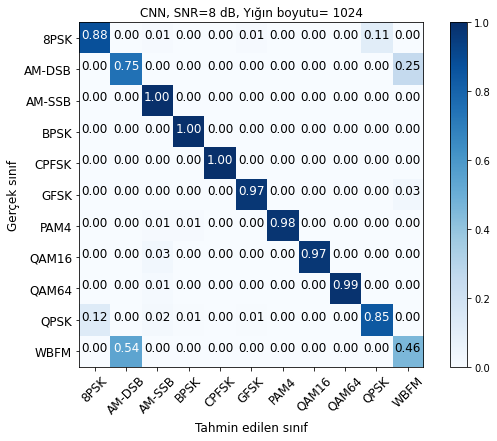

<Figure size 432x288 with 0 Axes>

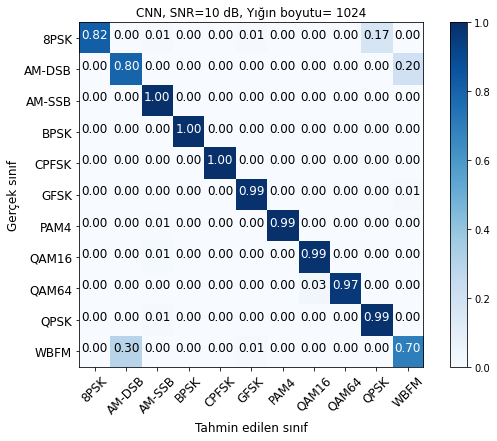

<Figure size 432x288 with 0 Axes>

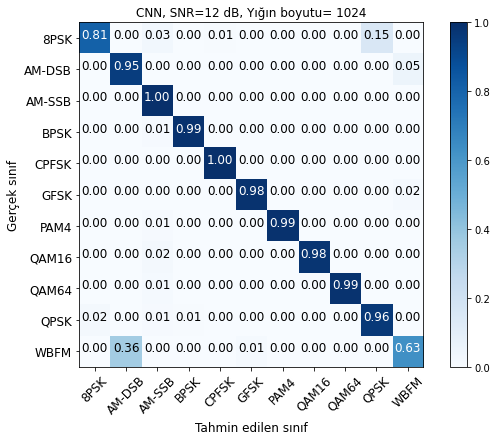

<Figure size 432x288 with 0 Axes>

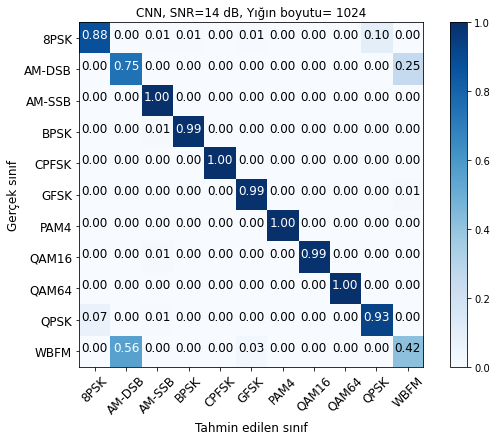

<Figure size 432x288 with 0 Axes>

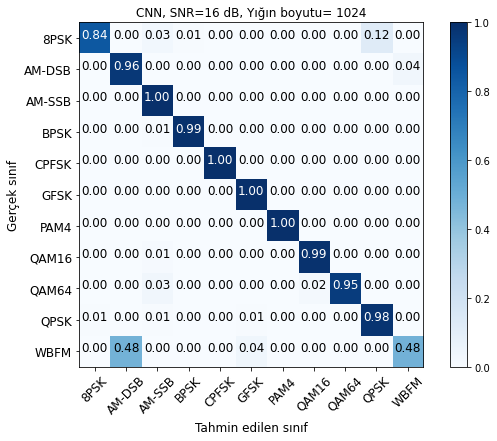

<Figure size 432x288 with 0 Axes>

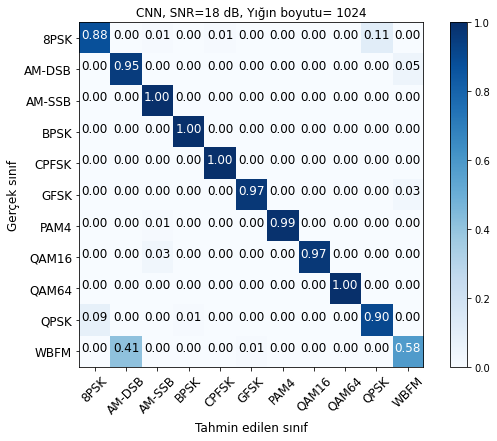

In [28]:
acc1 = plot_cm_snr(trained_model1, batchsize1)
acc2 = plot_cm_snr(trained_model2, batchsize2) 
acc3 = plot_cm_snr(trained_model3, batchsize3) 
acc4 = plot_cm_snr(trained_model4, batchsize4) 

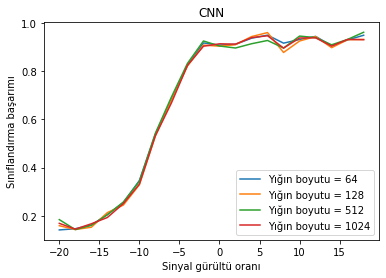

In [29]:
# Plot accuracy curve
plt.plot(SNRs, list(map(lambda x: acc1[x], SNRs)), label = 'Yığın boyutu = 64')
plt.plot(SNRs, list(map(lambda x: acc2[x], SNRs)), label = 'Yığın boyutu = 128')
plt.plot(SNRs, list(map(lambda x: acc3[x], SNRs)), label = 'Yığın boyutu = 512')
plt.plot(SNRs, list(map(lambda x: acc4[x], SNRs)), label = 'Yığın boyutu = 1024')
plt.title("CNN")
plt.xlabel("Sinyal gürültü oranı")
plt.ylabel("Sınıflandırma başarımı")
plt.legend()

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score


In [31]:
# Confusion Matrix
print("Yığın boyutu - 64 sonuçları")
y_pred = trained_model1.predict(X_test, batch_size=batchsize1)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 64 sonuçları
roc_auc_score:  0.9499566440047548
mean_absolute_error:  0.0663474902803315
mean_squared_error:  0.03409825445694388
r2_score:  0.5885684991021999


array([0.50665557, 0.5819556 , 0.66028037, 0.63434753, 0.61520706,
       0.6461026 , 0.71071913, 0.72002141, 0.80237154, 0.52840021,
       0.43251726])

In [32]:
# Confusion Matrix
print("Yığın boyutu - 128 sonuçları")
y_pred = trained_model2.predict(X_test, batch_size=batchsize2)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 128 sonuçları
roc_auc_score:  0.9500244240544636
mean_absolute_error:  0.06703597179108478
mean_squared_error:  0.03441192467636964
r2_score:  0.5830103103600044


array([0.51747088, 0.52739726, 0.65607477, 0.62974983, 0.61059063,
       0.63357761, 0.72048847, 0.71627409, 0.73675889, 0.52006253,
       0.4687173 ])

In [33]:
# Confusion Matrix
print("Yığın boyutu - 512 sonuçları")
y_pred = trained_model3.predict(X_test, batch_size=batchsize3)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 512 sonuçları
roc_auc_score:  0.9513777773533135
mean_absolute_error:  0.06648110064966913
mean_squared_error:  0.03387804383573231
r2_score:  0.592482079099743


array([0.51788686, 0.58360888, 0.66285047, 0.63245436, 0.61357773,
       0.62838108, 0.70474898, 0.7232334 , 0.79130435, 0.52449192,
       0.41745135])

In [34]:
# Confusion Matrix
print("Yığın boyutu - 1024 sonuçları")
y_pred = trained_model4.predict(X_test, batch_size=batchsize4)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 1024 sonuçları
roc_auc_score:  0.9500727603917464
mean_absolute_error:  0.06665377349899669
mean_squared_error:  0.03437741755922379
r2_score:  0.5861358397364078


array([0.50457571, 0.61242324, 0.64579439, 0.62785666, 0.62973523,
       0.61852099, 0.71207598, 0.70449679, 0.76916996, 0.53230849,
       0.41263863])